# Time-Series Research Project

- Researched by Shane Stoll
- Advised by Uzma Mushtaque

# Libraries to import

In [36]:
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import yfinance as yf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import pandas_ta as ta
from projectpro import model_snapshot, checkpoint
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Bidirectional, GRU
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop, Nadam, Adagrad, Adadelta, SGD
from keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [37]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#yf.pdr_override()
%matplotlib inline

In [38]:
# Fetch NVIDIA data (Scaled using Min-Max Scaler with relevant columns (Open, High, Low, Close, Adjusted Close, and Volume) normalized to values between 0 and 1)
dataset = yf.download('NVDA', start='2010-01-01', end='2024-08-28')
#dataset2 = yf.download('NVDA', start='2010-01-01', end='2024-08-28')
#dataset3 = yf.download('NVDA', start='2010-01-01', end='2024-08-28')

# Display the first few rows
print(dataset.head())

# Save the data to a CSV file
dataset.to_csv('nvidia_stock_data.csv')


[*********************100%***********************]  1 of 1 completed

               Open    High      Low    Close  Adj Close     Volume
Date                                                               
2010-01-04  0.46275  0.4655  0.45275  0.46225   0.423923  800204000
2010-01-05  0.46050  0.4740  0.46050  0.46900   0.430113  728648000
2010-01-06  0.46875  0.4730  0.46425  0.47200   0.432864  649168000
2010-01-07  0.46950  0.4715  0.45925  0.46275   0.424381  547792000
2010-01-08  0.45900  0.4670  0.45625  0.46375   0.425298  478168000


In [116]:
def train_test_plot(dataset, tstart, tend, title):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title(title)
    plt.show()

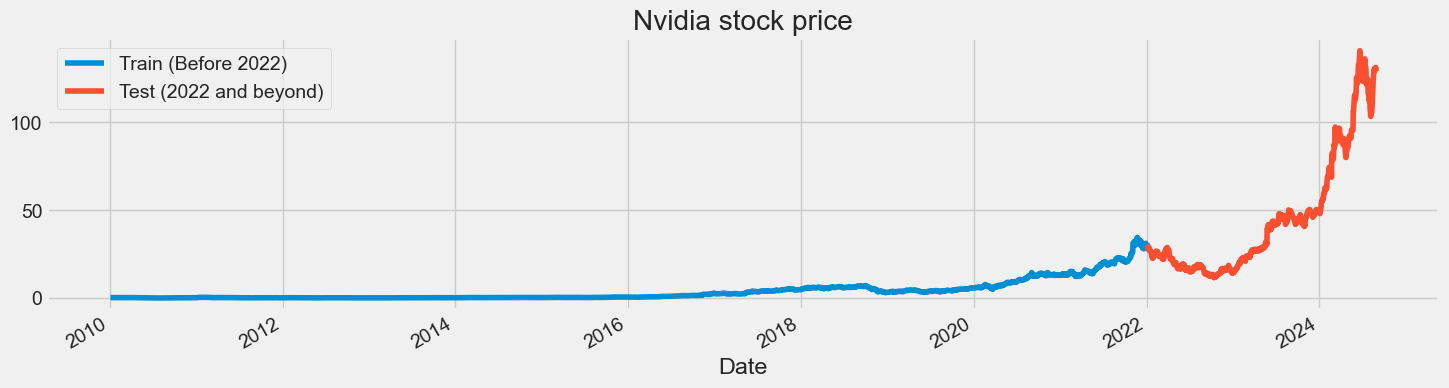

In [119]:
tstart = 2010
tend = 2021

train_test_plot(dataset, tstart, tend, "Nvidia stock price")

# Create train and test datasets

In [41]:
# Check the column names in the dataset to ensure 'Date' is present
print(dataset.columns)

# Reload the dataset, ensuring the 'Date' column is there
dataset = pd.read_csv('nvidia_stock_data.csv')

# Convert 'Date' to datetime if necessary
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Set 'Date' as the index
dataset.set_index('Date', inplace=True)

# Verify the columns after processing
print(dataset.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [42]:
# Adjust the train_test_split function to use proper date strings and index
def train_test_split(dataset, train_start, train_end, columns=['High']):
    train = dataset.loc[train_start:train_end, columns].values
    test = dataset.loc[train_end:, columns].values
    return train, test

# Set correct date ranges for training and testing
train_start = '2010-01-01'
train_end = '2021-12-31'

# Split the data
training_set, test_set = train_test_split(dataset, train_start, train_end)

# Check the sizes of the training and test sets
print(f"Training set size: {len(training_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 3021
Test set size: 667


# Scaling dataset values

In [43]:
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set = training_set.reshape(-1, 1)
# training_set_scaled = sc.fit_transform(training_set)

# Initialize the MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
training_set_scaled = sc.fit_transform(training_set)

# Scale the test data
test_set_scaled = sc.transform(test_set)

# Creating overlapping window batches

In [44]:
n_steps = 60
features = 1

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [45]:
# Reshape into X=t and Y=t+1
# Split the training and test data into sequences
X_train, y_train = split_sequence(training_set_scaled, n_steps)
X_test, y_test = split_sequence(test_set_scaled, n_steps)

# Reshape the input data to 3D (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Evaluation

In [46]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(10,6))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
def return_mse(y_test_scaled, predicted_stock_price):
    mse = mean_squared_error(y_test_scaled, predicted_stock_price)
    print(f"Mean Squared Error: {mse:.2f}")

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
def return_mae(y_test_scaled, predicted_stock_price):
    mae = mean_absolute_error(y_test_scaled, predicted_stock_price)
    print(f"Mean Absolute Error: {mae:.2f}")

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
def return_rmse(y_test_scaled, predicted_stock_price):
    rmse = np.sqrt(mean_squared_error(y_test_scaled, predicted_stock_price))
    print(f"Root Mean Squared Error: {rmse:.2f}")

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
def return_mape(y_test_scaled, predicted_stock_price):
    mape = np.mean(np.abs((y_test_scaled - predicted_stock_price) / y_test_scaled)) * 100
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Returns all methods of evaluation
def return_evaluation(y_test_scaled, predicted_stock_price):
    return_mse(y_test_scaled, predicted_stock_price)
    return_mae(y_test_scaled, predicted_stock_price)
    return_rmse(y_test_scaled, predicted_stock_price)
    return_mape(y_test_scaled, predicted_stock_price)

# Recurrent Neural Network **(RNN)**

In [47]:
def build_and_train_rnn(X_train, y_train, X_test, y_test, 
                        units=150, 
                        dropout_rate=0.3, 
                        learning_rate=0.000005, 
                        epochs=200, 
                        batch_size=64, 
                        optimizer_type='adam', 
                        include_early_stopping=True, 
                        patience=10, 
                        return_sequences=True):
    """
    Builds, trains, and evaluates an RNN model with customizable parameters.

    Parameters:
        X_train, y_train, X_test, y_test: numpy arrays for training and testing data
        units (int): Number of RNN units
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for the optimizer
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        optimizer_type (str): Optimizer to use ('adam', 'sgd', 'rmsprop')
        include_early_stopping (bool): Whether to include early stopping
        patience (int): Patience for early stopping
        return_sequences (bool): Whether the RNN should return sequences
        
    Returns:
        model: Trained RNN model
        history: Training history object
        predicted_stock_price: Predicted stock prices (inverse transformed)
        y_test_scaled: Real stock prices (inverse transformed)
    """
    # Select optimizer
    if optimizer_type.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type.lower() == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_type.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(units=units, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=return_sequences))
    model.add(Dropout(dropout_rate))
    if return_sequences:
        model.add(SimpleRNN(units=units, activation='relu'))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Configure callbacks
    callbacks = []
    if include_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    
    # Plot loss
    plot_loss(history)
    
    # Predict stock prices
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot predictions
    plot_predictions(y_test_scaled, predicted_stock_price, "Stock Price Prediction with RNN")
    
    return model, history, predicted_stock_price, y_test_scaled

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0338 - val_loss: 1.9268
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0244 - val_loss: 1.6729
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0229 - val_loss: 1.4224
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0192 - val_loss: 1.2015
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0157 - val_loss: 0.9863
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0131 - val_loss: 0.7904
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0097 - val_loss: 0.5955
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0070 - val_loss: 0.4198
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0052 - val_loss: 0.2732
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - val_loss: 0.1702
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0957
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

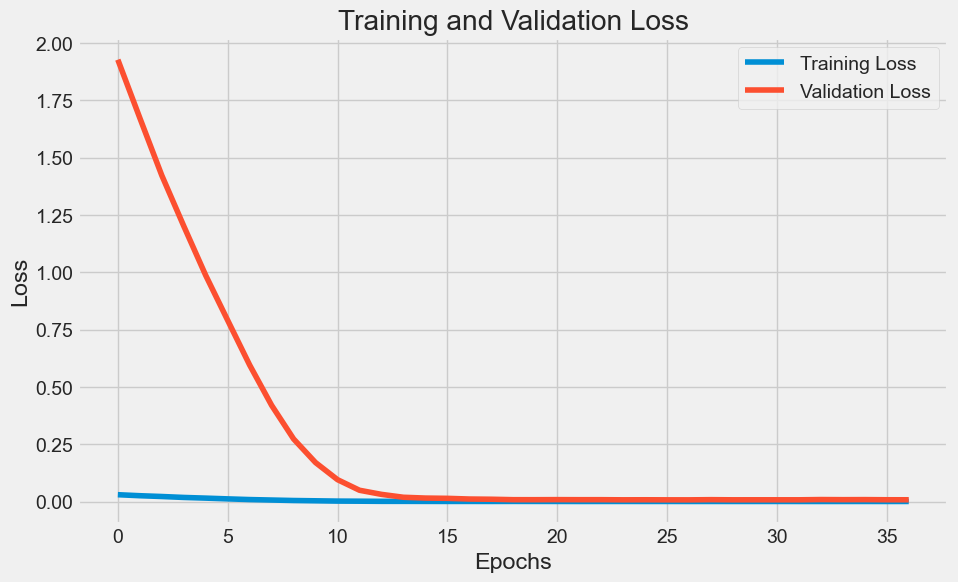

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


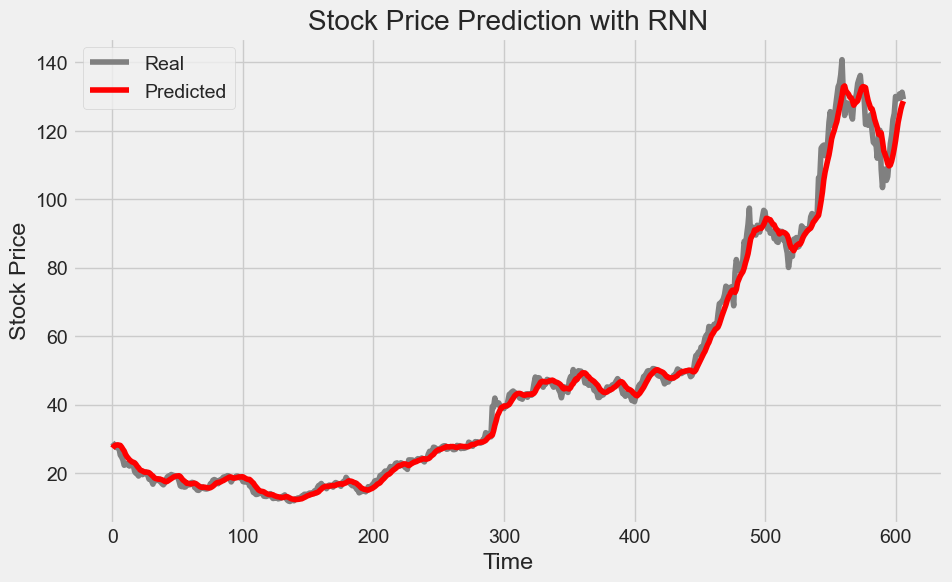

In [48]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_rnn(X_train, y_train, X_test, y_test, optimizer_type='rmsprop')

### Calculate the error for different evaluation metrics

In [49]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 9.14
Mean Absolute Error: 1.93
Root Mean Squared Error: 3.02
Mean Absolute Percentage Error: 4.24%


### RNN Conclusion

#### Evaluation Metrics:

- Mean Squared Error (MSE = 9.14): 

This value represents the squared difference between predicted and actual stock prices. While it is slightly higher than previous iterations, it remains relatively low, suggesting that the model captures the overall trend effectively.

- Mean Absolute Error (MAE = 1.93): 

On average, the model’s predictions are $1.93 off from the actual stock prices, demonstrating strong performance in predicting stock price movements.

- Root Mean Squared Error (RMSE = 3.02): 

This metric, which is more sensitive to larger prediction errors, indicates an average deviation of $3.02 from actual prices. Despite being slightly higher than previous runs, it remains within a reasonable range for financial forecasting.

- Mean Absolute Percentage Error (MAPE = 4.24%): 

A MAPE of 4.44% is very good for stock price forecasting, as values below 5% are considered highly accurate in the field.

#### Interpretation:

The graph looks quite good as the model closely follows the actual stock prices, with only minor deviations. The performance is particularly strong during periods of stable growth, and even during more volatile periods, the model tracks the overall trend well. 

The error metrics (especially MAE and MAPE) indicate that the model is making very accurate predictions, with minimal error in terms of both absolute values (dollars) and relative percentage.

# Long-short Term Model **(LSTM)**

In [111]:
def build_and_train_lstm(X_train, y_train, X_test, y_test,
                         n_steps=30,
                         units=300,
                         dropout_rate=0.3,
                         learning_rate=0.0003,
                         epochs=200,
                         batch_size=32,
                         optimizer_type='adam',
                         amsgrad=False,
                         include_early_stopping=True,
                         patience=10,
                         return_sequences=True,
                         title="Stock Price Prediction with LSTM"):
    """
    Builds, trains, and evaluates an LSTM model with customizable parameters.

    Parameters:
        X_train, y_train, X_test, y_test: numpy arrays for training and testing data
        n_steps (int): Number of time steps
        units (int): Number of LSTM units
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for the optimizer
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        optimizer_type (str): Optimizer to use ('adam', 'rmsprop', 'nadam', 'adagrad', 'adadelta', 'sgd')
        include_early_stopping (bool): Whether to include early stopping
        patience (int): Patience for early stopping
        return_sequences (bool): Whether the LSTM should return sequences
        title (str): Title for the prediction plot

    Returns:
        model: Trained LSTM model
        history: Training history object
        predicted_stock_price: Predicted stock prices (inverse transformed)
        y_test_scaled: Real stock prices (inverse transformed)
    """
    # Select optimizer
    optimizer_type = optimizer_type.lower()
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'adam_amsgrad': Adam(learning_rate=learning_rate, amsgrad=amsgrad),  # Adam with AMSGrad
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate),
        'adagrad': Adagrad(learning_rate=learning_rate),
        'adadelta': Adadelta(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)  # With momentum
    }
    optimizer = optimizers.get(optimizer_type)
    if optimizer is None:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=return_sequences))
    model.add(Dropout(dropout_rate))
    if return_sequences:
        model.add(LSTM(units=units, activation='relu'))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Configure callbacks
    callbacks = []
    if include_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    
    # Plot training and validation loss
    plot_loss(history)
    
    # Predict stock prices
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot predictions
    plot_predictions(y_test_scaled, predicted_stock_price, title)
    
    return model, history, predicted_stock_price, y_test_scaled

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.0142 - val_loss: 0.3274
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 4.3078e-04 - val_loss: 0.0463
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 3.3557e-04 - val_loss: 0.0350
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 2.7540e-04 - val_loss: 0.0155
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 2.3135e-04 - val_loss: 0.0294
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 2.5266e-04 - val_loss: 0.0428
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 2.6732e-04 - val_loss: 0.0109
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 2.1776e-04 - val_loss: 0.0261
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 1.8543e-04 - val_loss: 0.0477
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 2.1089e-04 - val_loss: 0.0207
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 2.1605e-04 - val_loss: 0.0290
Epoch 12/200
93/93 

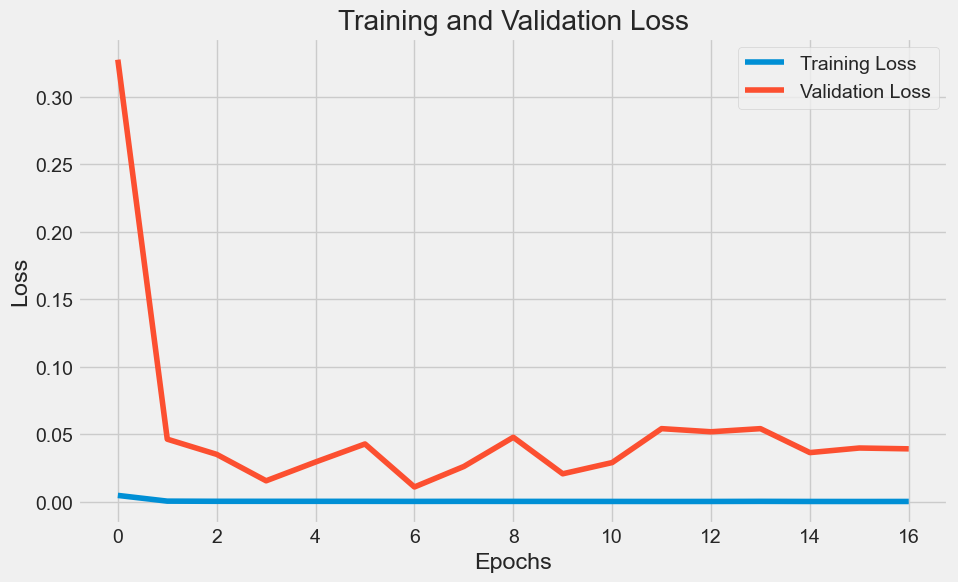

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


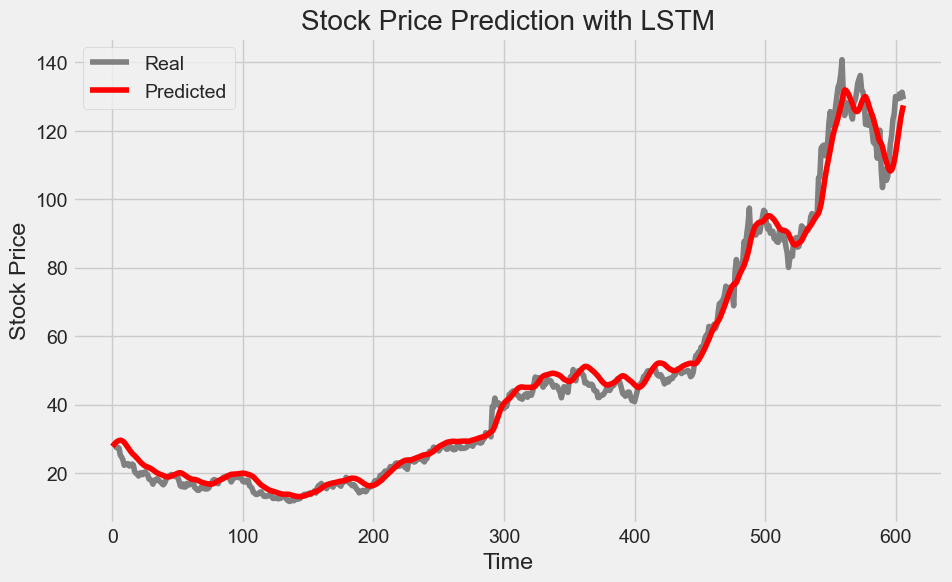

In [51]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, optimizer_type='adam')

In [52]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 12.91
Mean Absolute Error: 2.56
Root Mean Squared Error: 3.59
Mean Absolute Percentage Error: 6.67%


### Initial LSTM Conclusion
#### Evaluation Metrics:
- Mean Squared Error (MSE = 12.91):

This value indicates a larger discrepancy between predicted and actual stock prices compared to the RNN model, suggesting that the initial LSTM configuration struggles to capture the trends accurately.

- Mean Absolute Error (MAE = 2.56):

On average, the model’s predictions are $2.56 off from the actual stock prices, which is a noticeable increase in error compared to the RNN model.

- Root Mean Squared Error (RMSE = 3.59):

The RMSE highlights that the model’s errors are larger and more significant than the RNN model's, showing reduced performance in capturing the stock price patterns.

- Mean Absolute Percentage Error (MAPE = 6.67%):

A MAPE of 6.67% indicates that the relative error is above the generally acceptable threshold of 5%, further emphasizing the model’s underperformance compared to the RNN.

#### Interpretation:

The initial LSTM configuration, using the Adam optimizer with early stopping, yields worse results than the RNN model in all metrics. This suggests that the current hyperparameter settings may not be optimal for this dataset or that early stopping is prematurely halting training before the model can converge effectively.

To address these issues, the next steps will include experimenting with different optimizers (e.g., RMSprop or SGD) and testing a version of the LSTM model without early stopping to evaluate its impact on performance. Further tuning of hyperparameters, such as the learning rate and number of units, may also improve results.

### LSTM with RMSprop optimizer

We'll try using the RMSprop optimizer, which often works well with recurrent neural networks like LSTM. RMSprop adapts the learning rate based on recent gradients, which can be beneficial for time series data.

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.0164 - val_loss: 0.0541
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 4.7191e-04 - val_loss: 0.0430
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 3.9055e-04 - val_loss: 0.0349
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 4.1338e-04 - val_loss: 0.0325
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 3.1182e-04 - val_loss: 0.0726
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 3.0876e-04 - val_loss: 0.0312
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 2.6611e-04 - val_loss: 0.0322
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 3.5392e-04 - val_loss: 0.0289
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 2.6517e-04 - val_loss: 0.0281
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 3.9764e-04 - val_loss: 0.0285
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 2.6112e-04 - val_loss: 0.0228
Ep

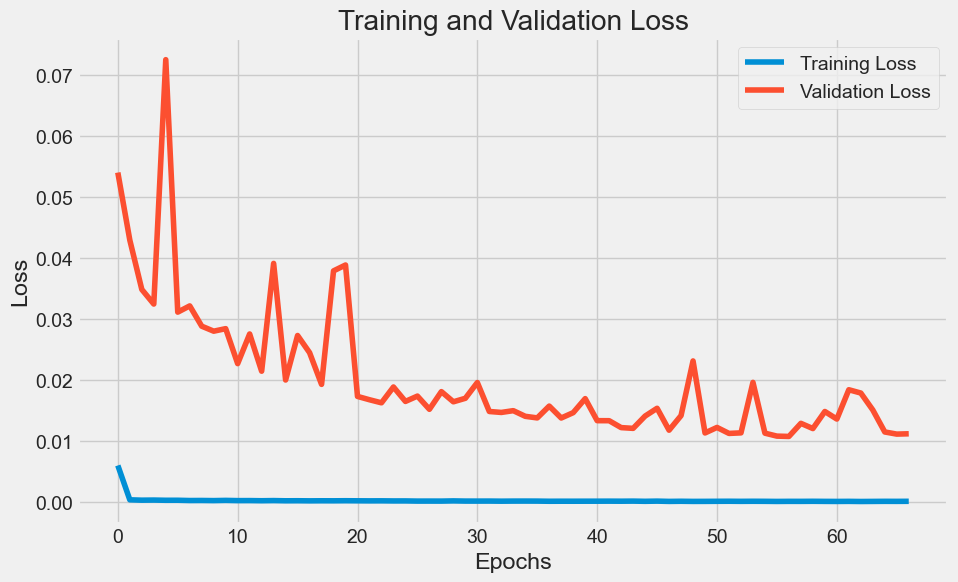

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


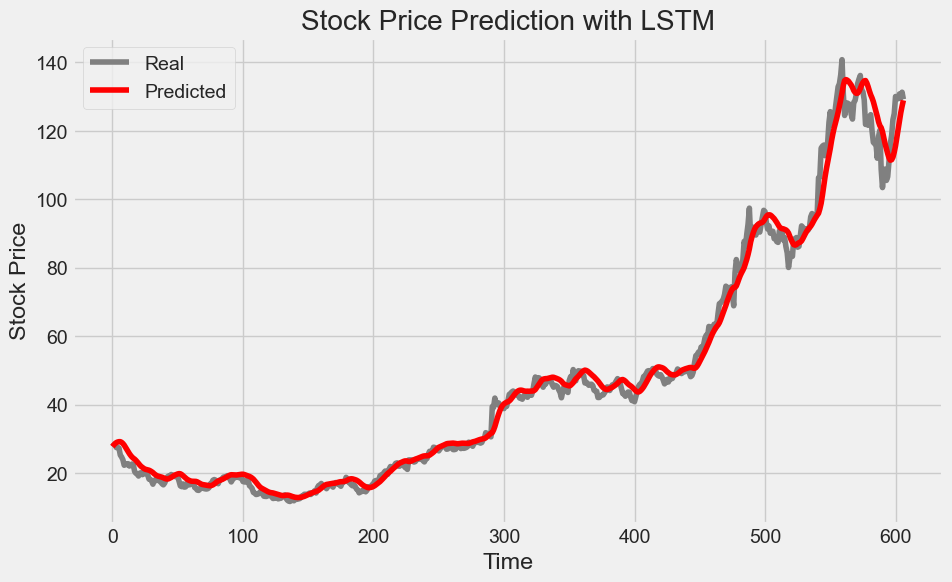

In [82]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='rmsprop')

In [83]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 12.82
Mean Absolute Error: 2.40
Root Mean Squared Error: 3.58
Mean Absolute Percentage Error: 5.65%


### LSTM with RMSprop and Early Stopping Conclusion

### Evaluation Metrics:
- Mean Squared Error (MSE = 12.82):

This value is lower than the initial LSTM with Adam optimizer, indicating improved accuracy in capturing the overall trends of stock price movements.

- Mean Absolute Error (MAE = 2.40):

On average, the model’s predictions are $2.47 off from the actual stock prices, showing a slight improvement over the initial LSTM model but still higher than the RNN.

- Root Mean Squared Error (RMSE = 3.58):

The RMSE indicates an average error of $3.64, which is a reduction compared to the initial LSTM but still higher than the RNN model.

- Mean Absolute Percentage Error (MAPE = 5.65%):

The MAPE value remains above the 5% threshold, showing that while the model's absolute errors improved, its relative error has slightly increased compared to the initial LSTM.

- Interpretation:

Switching to the RMSprop optimizer has led to improved performance across most metrics compared to the initial LSTM configuration with Adam. However, the model still underperforms relative to the RNN model in terms of accuracy and error metrics.

The MAPE suggests that the model struggles with relative accuracy, possibly due to limitations in capturing specific trends or handling volatile data. Future experiments could involve removing early stopping to allow the model more training time or further tuning the optimizer’s learning rate and hyperparameters.

Overall, the LSTM with RMSprop and early stopping demonstrates moderate improvements over the initial configuration, but further optimization is needed to match or exceed the RNN’s performance.



### LSTM with RMSprop optimizer without Early Stopping

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.0146 - val_loss: 0.0370
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 3.1578e-04 - val_loss: 0.0323
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 4.2780e-04 - val_loss: 0.0382
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 4.1072e-04 - val_loss: 0.1094
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 4.1265e-04 - val_loss: 0.0322
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 3.2335e-04 - val_loss: 0.0358
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 3.7191e-04 - val_loss: 0.0299
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 3.5820e-04 - val_loss: 0.0280
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 3.2351e-04 - val_loss: 0.0378
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 3.5391e-04 - val_loss: 0.0239
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 2.9242e-04 - val_loss: 0.0234
Ep

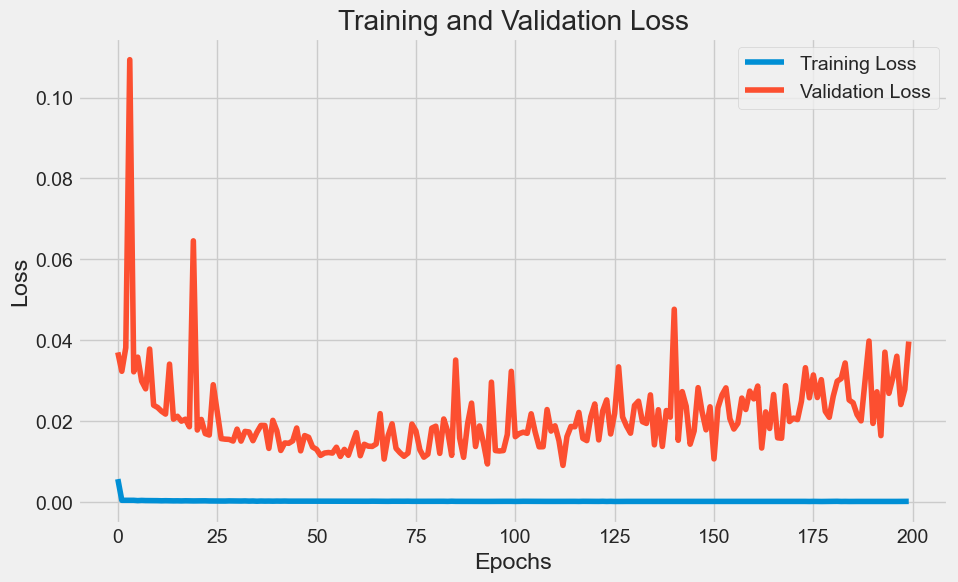

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


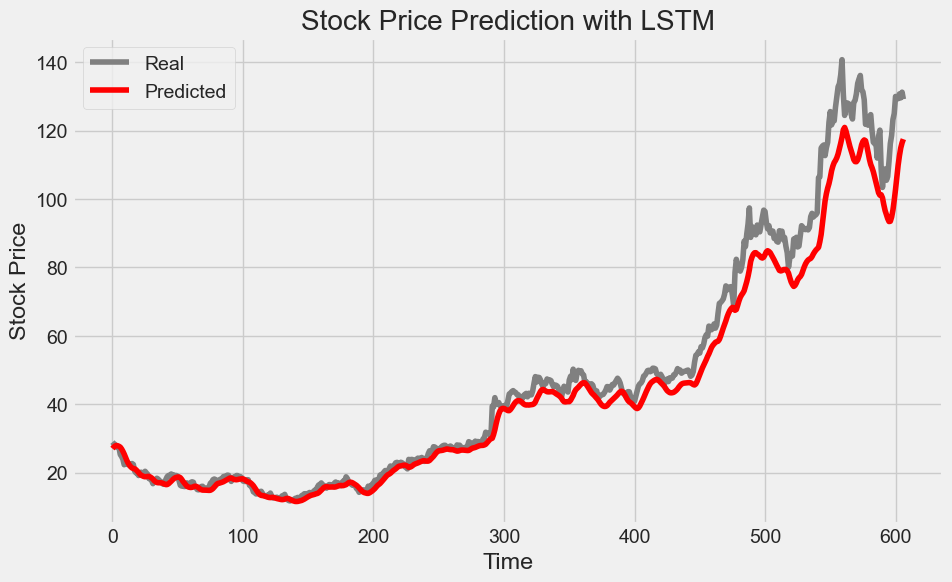

In [84]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='rmsprop', include_early_stopping=False)

In [85]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 47.01
Mean Absolute Error: 4.39
Root Mean Squared Error: 6.86
Mean Absolute Percentage Error: 7.49%


### LSTM with RMSprop and No Early Stopping Conclusion

#### Evaluation Metrics:
- Mean Squared Error (MSE = 47.01):

This significantly higher value indicates that removing early stopping leads to a poorer fit, as the model may overfit to the training data or fail to generalize effectively.

- Mean Absolute Error (MAE = 4.39):

On average, the model’s predictions are $4.39 off from the actual stock prices, showing a notable decline in performance compared to the version with early stopping.

- Root Mean Squared Error (RMSE = 6.86):

The RMSE highlights larger errors in the predictions, further confirming that the absence of early stopping negatively impacts the model’s accuracy.

- Mean Absolute Percentage Error (MAPE = 7.49%):

Although the relative error is slightly lower than the initial LSTM, it is still higher than the LSTM with RMSprop and early stopping, suggesting that this configuration struggles with consistent accuracy.

#### Interpretation:

The results indicate that removing early stopping significantly worsens the performance of the LSTM with RMSprop. While RMSprop is effective at handling sequence data, the lack of early stopping likely led the model to train for too many epochs, causing overfitting and reducing its ability to generalize to unseen data.

Comparatively, the version of LSTM with RMSprop and early stopping achieved the best results among the LSTM configurations, with relatively lower MSE, MAE, RMSE, and MAPE values. This reinforces the importance of early stopping in preventing overfitting and enabling better generalization in this stock prediction task.

Moving forward, further tuning of hyperparameters (e.g., learning rate, number of units) and experimenting with regularization techniques could help improve performance while maintaining the benefits of early stopping.

### LSTM with different Optimizers

We'll experiment with Nadam, Adagrad, Adadelta, SGD with Momentum, and AMSGrad optimizers to see if they perform better than RMSprop

#### Nadam Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - loss: 0.0104 - val_loss: 0.1000
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 2.9534e-04 - val_loss: 0.0156
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 3.1026e-04 - val_loss: 0.0300
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 1.9191e-04 - val_loss: 0.0396
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 2.4321e-04 - val_loss: 0.0523
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 1.6328e-04 - val_loss: 0.0661
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 1.9599e-04 - val_loss: 0.0888
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 1.5115e-04 - val_loss: 0.0525
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 1.5197e-04 - val_loss: 0.0536
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 1.8385e-04 - val_loss: 0.0875
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 1.4513e-04 - val_loss: 0.0957
Ep

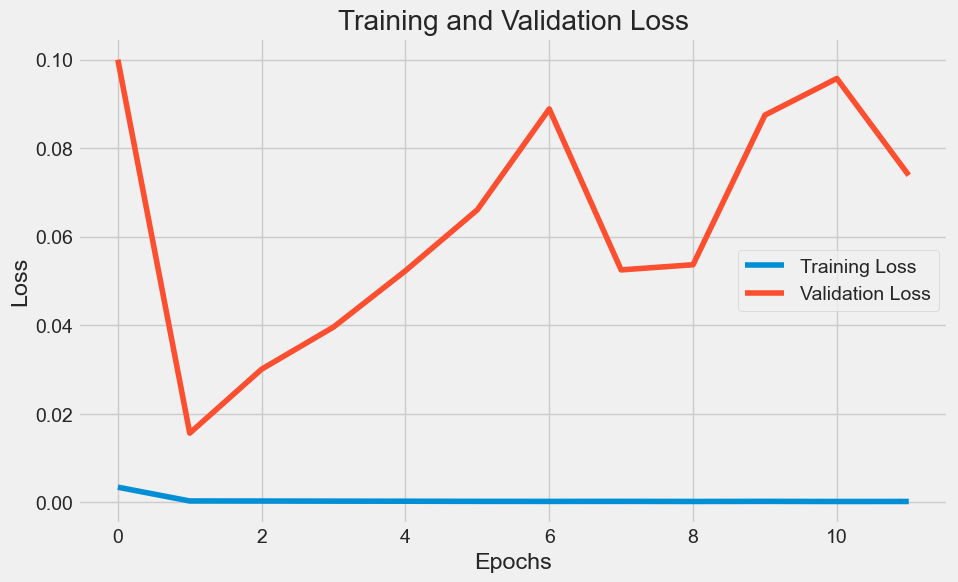

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


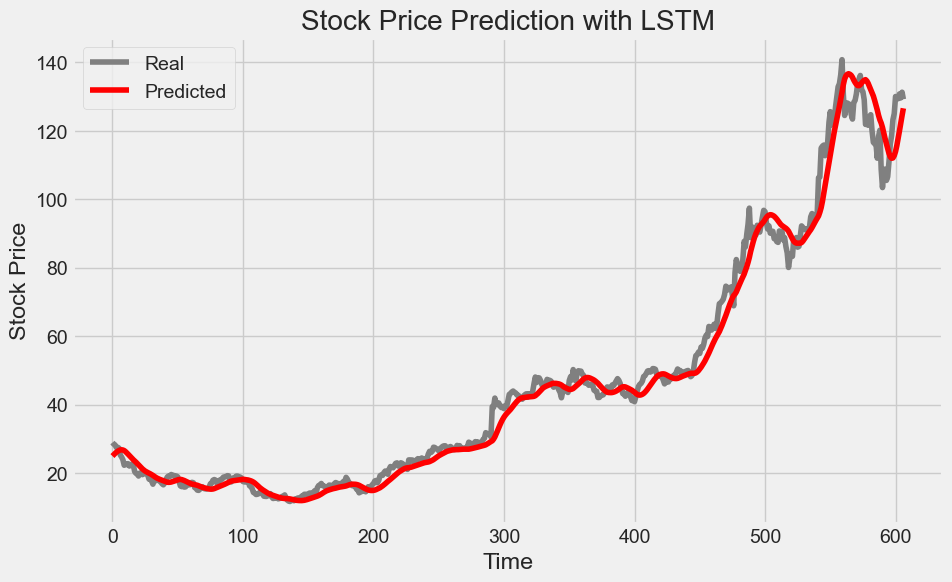

In [86]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='nadam')

In [87]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 18.48
Mean Absolute Error: 2.97
Root Mean Squared Error: 4.30
Mean Absolute Percentage Error: 6.68%


#### Adagrad Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0397 - val_loss: 2.8286
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0375 - val_loss: 2.7739
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0389 - val_loss: 2.7271
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0329 - val_loss: 2.6852
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 0.0348 - val_loss: 2.6469
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0313 - val_loss: 2.6114
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0339 - val_loss: 2.5786
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.0294 - val_loss: 2.5482
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0307 - val_loss: 2.5196
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0288 - val_loss: 2.4927
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0287 - val_loss: 2.4672
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11

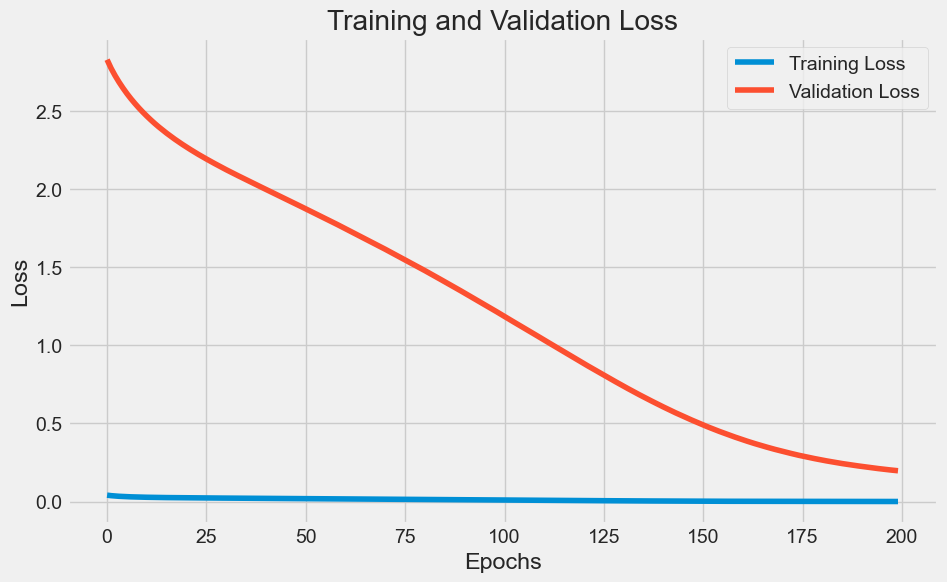

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


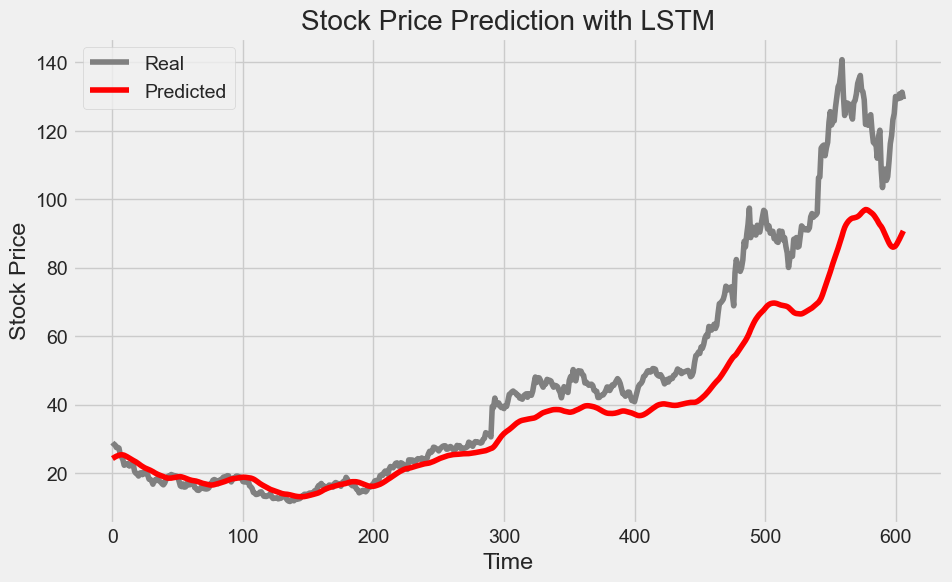

In [88]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='adagrad')

In [89]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 233.72
Mean Absolute Error: 10.02
Root Mean Squared Error: 15.29
Mean Absolute Percentage Error: 16.05%


#### Adadelta Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - loss: 0.0403 - val_loss: 2.8957
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0449 - val_loss: 2.8897
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0455 - val_loss: 2.8837
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0444 - val_loss: 2.8777
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 0.0440 - val_loss: 2.8716
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0408 - val_loss: 2.8655
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0392 - val_loss: 2.8593
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0402 - val_loss: 2.8531
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0450 - val_loss: 2.8469
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0431 - val_loss: 2.8407
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0415 - val_loss: 2.8344
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11

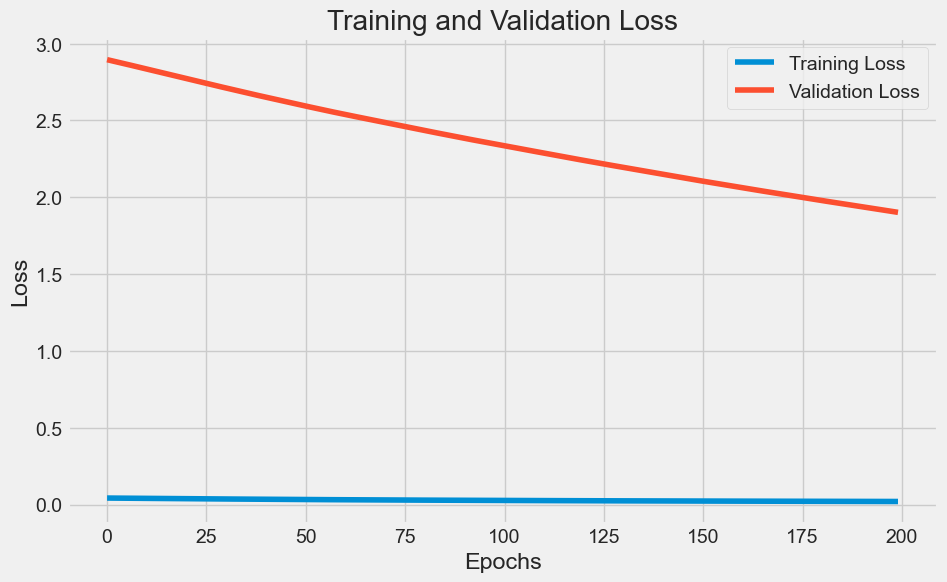

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


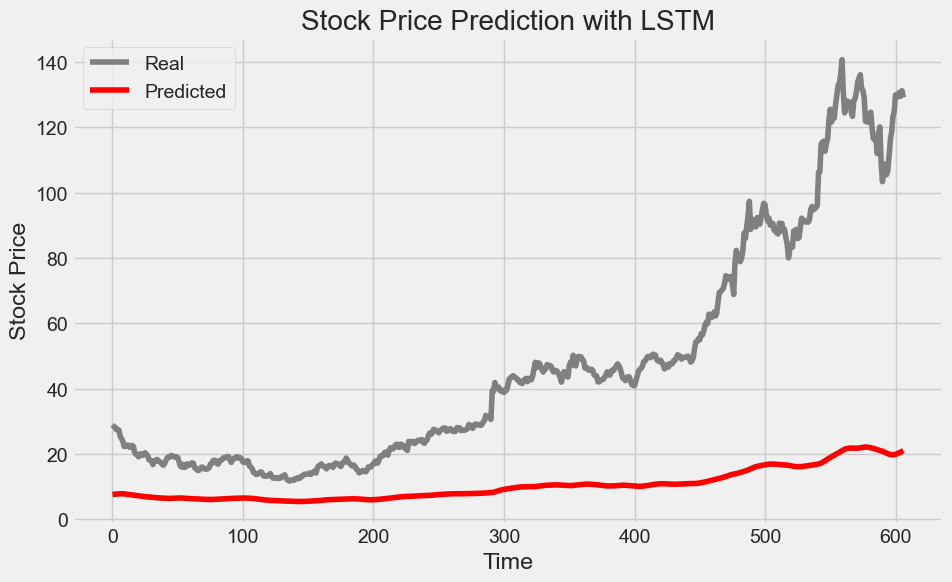

In [90]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='adadelta')

In [91]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 2253.64
Mean Absolute Error: 36.64
Root Mean Squared Error: 47.47
Mean Absolute Percentage Error: 72.53%


#### SGD with Momentum Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 0.0388 - val_loss: 2.5278
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.0273 - val_loss: 2.3889
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.0280 - val_loss: 2.3113
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.0267 - val_loss: 2.2489
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0230 - val_loss: 2.1993
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0217 - val_loss: 2.1487
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0219 - val_loss: 2.1004
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.0211 - val_loss: 2.0546
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 0.0209 - val_loss: 2.0102
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.0191 - val_loss: 1.9634
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 0.0186 - val_loss: 1.9206
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11

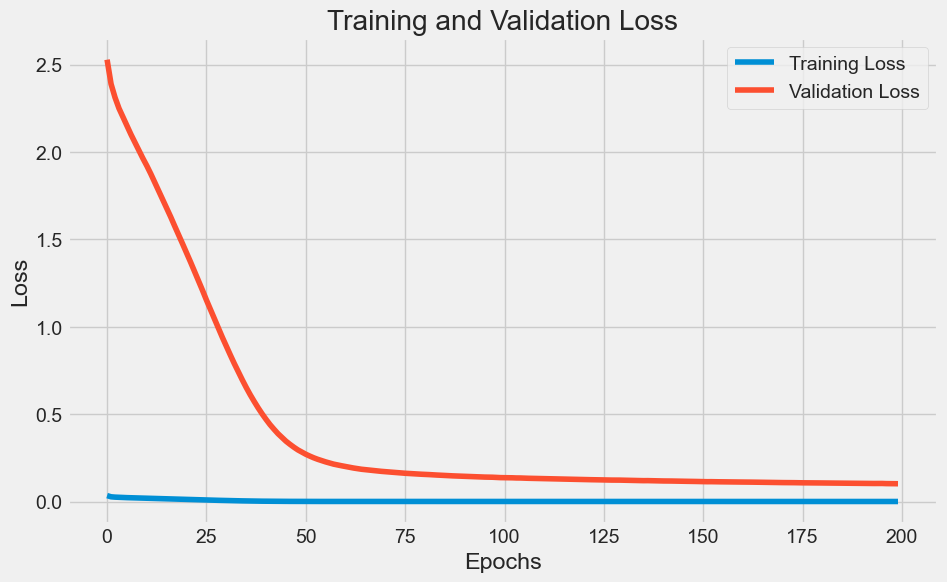

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


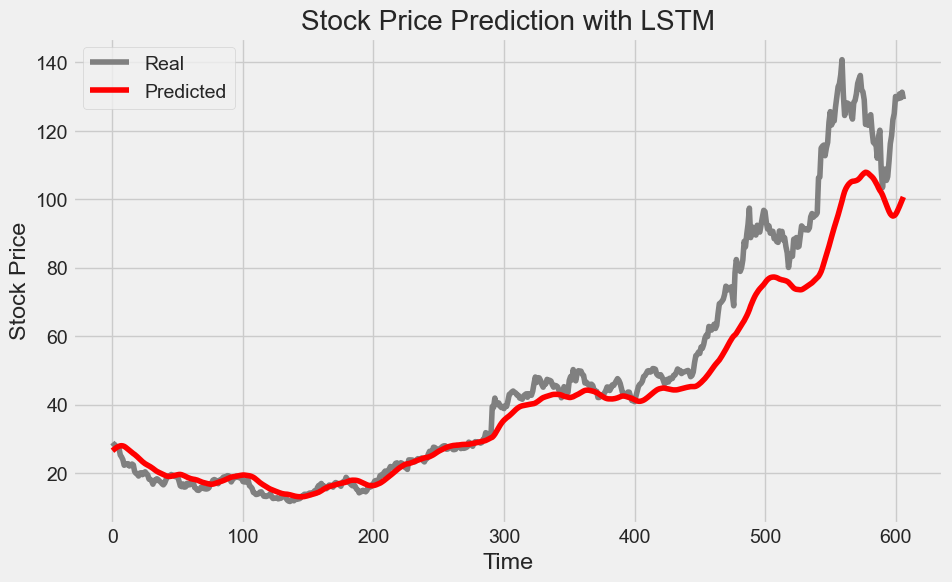

In [92]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='sgd')

In [93]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 120.63
Mean Absolute Error: 6.72
Root Mean Squared Error: 10.98
Mean Absolute Percentage Error: 11.24%


#### Adam with AMSgrad Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 0.0134 - val_loss: 0.3320
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 3.5371e-04 - val_loss: 0.0197
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 2.7627e-04 - val_loss: 0.0145
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 1.9978e-04 - val_loss: 0.0515
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 2.8354e-04 - val_loss: 0.0251
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 2.9303e-04 - val_loss: 0.0341
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - loss: 2.0284e-04 - val_loss: 0.0685
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 1.7166e-04 - val_loss: 0.0561
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 2.7869e-04 - val_loss: 0.0558
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 1.7730e-04 - val_loss: 0.0585
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - loss: 1.6870e-04 - val_loss: 0.0619
Ep

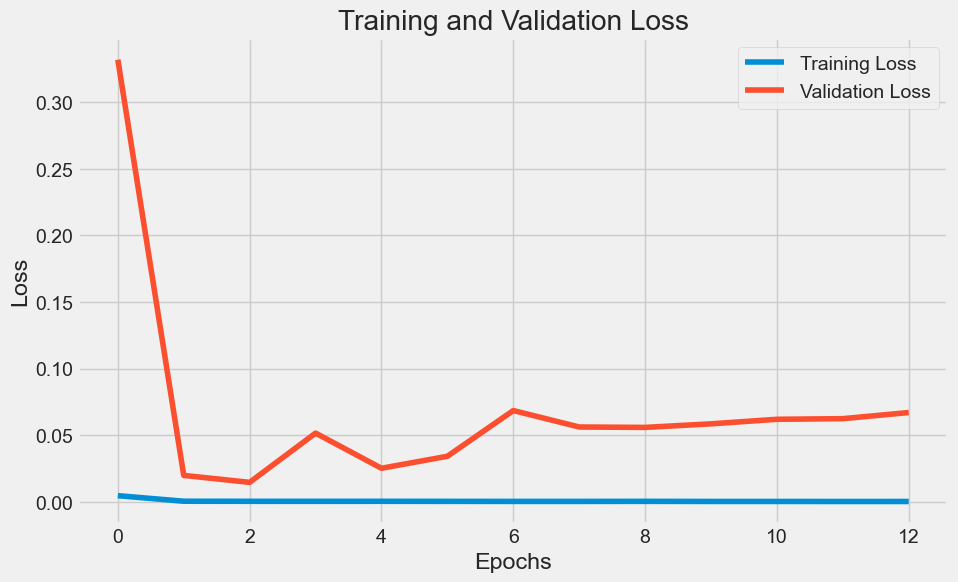

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


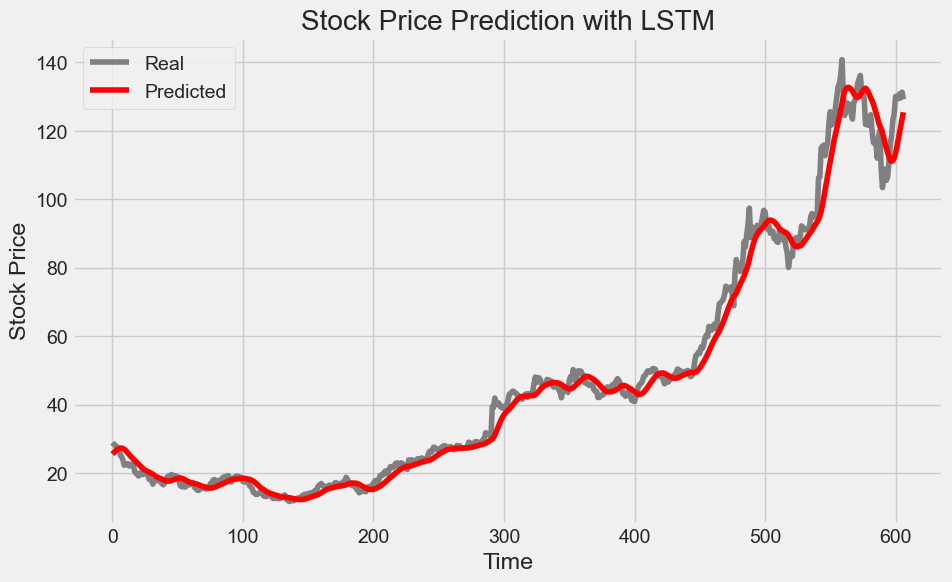

In [113]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='adam_amsgrad', amsgrad=True)

In [114]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 17.21
Mean Absolute Error: 2.81
Root Mean Squared Error: 4.15
Mean Absolute Percentage Error: 6.30%


## Bi Directional LSTM with RMSprop Optimizer

In [96]:
def build_and_train_bilstm(X_train, y_train, X_test, y_test,
                           n_steps=150,
                           units=300,
                           dropout_rate=0.3,
                           learning_rate=0.0005,
                           epochs=200,
                           batch_size=32,
                           optimizer_type='rmsprop',
                           include_early_stopping=True,
                           patience=10,
                           return_sequences=True,
                           title="Stock Price Prediction with Bi-Directional LSTM"):
    """
    Builds, trains, and evaluates a Bi-Directional LSTM model with customizable parameters.

    Parameters:
        X_train, y_train, X_test, y_test: numpy arrays for training and testing data
        n_steps (int): Number of time steps
        units (int): Number of Bi-LSTM units
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for the optimizer
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        optimizer_type (str): Optimizer to use ('adam', 'rmsprop', 'nadam', etc.)
        include_early_stopping (bool): Whether to include early stopping
        patience (int): Patience for early stopping
        return_sequences (bool): Whether the Bi-LSTM should return sequences
        title (str): Title for the prediction plot

    Returns:
        model: Trained Bi-LSTM model
        history: Training history object
        predicted_stock_price: Predicted stock prices (inverse transformed)
        y_test_scaled: Real stock prices (inverse transformed)
    """
    # Select optimizer
    optimizer_type = optimizer_type.lower()
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate),
        'adagrad': Adagrad(learning_rate=learning_rate),
        'adadelta': Adadelta(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    }
    optimizer = optimizers.get(optimizer_type)
    if optimizer is None:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Build the Bi-LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, activation='relu', return_sequences=return_sequences), input_shape=(n_steps, 1)))
    model.add(Dropout(dropout_rate))
    if return_sequences:
        model.add(Bidirectional(LSTM(units=units, activation='relu')))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Configure callbacks
    callbacks = []
    if include_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    
    # Plot training and validation loss
    plot_loss(history)
    
    # Predict stock prices
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot predictions
    plot_predictions(y_test_scaled, predicted_stock_price, title)
    
    return model, history, predicted_stock_price, y_test_scaled

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 337ms/step - loss: 0.0104 - val_loss: 0.0290
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step - loss: 4.5569e-04 - val_loss: 0.0236
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 335ms/step - loss: 4.4149e-04 - val_loss: 0.0320
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 334ms/step - loss: 4.5687e-04 - val_loss: 0.0224
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 337ms/step - loss: 3.7971e-04 - val_loss: 0.0428
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 340ms/step - loss: 2.8646e-04 - val_loss: 0.1928
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 341ms/step - loss: 5.0256e-04 - val_loss: 0.0240
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 340ms/step - loss: 2.9747e-04 - val_loss: 0.0207
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 343ms/step - loss: 3.4016e-04 - val_loss: 0.0242
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 342ms/step - loss: 3.1076e-04 - val_loss: 0.0202
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 342ms/step - loss: 2.3765e-04 - val_loss: 0.0263
Ep

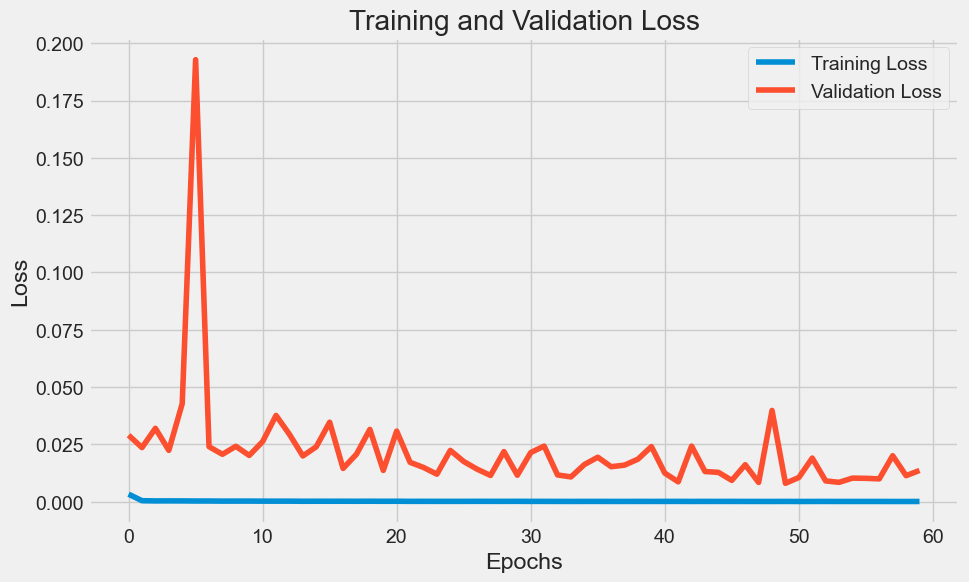

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


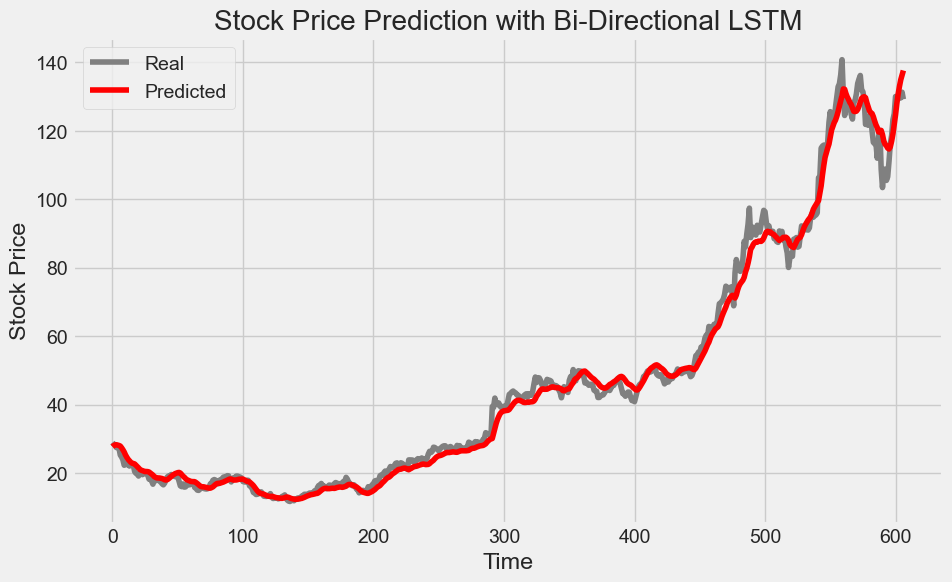

In [97]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_bilstm(X_train, y_train, X_test, y_test, optimizer_type='rmsprop')

In [98]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 9.55
Mean Absolute Error: 2.17
Root Mean Squared Error: 3.09
Mean Absolute Percentage Error: 5.19%


## Final Conclusion for LSTM

### Performance Summary:
Based on the tested configurations, the following insights were observed:

1. **RMSprop Optimizer with Early Stopping:**  
   RMSprop remains a strong contender, achieving relatively low error values in most metrics. When paired with Bi-Directional LSTM, it delivered the best performance among all LSTM variants:
   - **Bi-Directional LSTM with RMSprop:**
     - MSE: 9.55
     - MAE: 2.17
     - RMSE: 3.09
     - MAPE: 5.19%
   - These results outperform all standard LSTMs and demonstrate the added benefit of leveraging a Bi-Directional architecture to improve temporal learning.

2. **Nadam Optimizer with Early Stopping:**  
   The Nadam optimizer produced mixed results:
   - MSE: 18.48
   - MAE: 2.97
   - RMSE: 4.30
   - MAPE: 6.68%
   - While slightly better than Adagrad, Adadelta, and SGD with momentum, it fell short of the performance achieved by RMSprop.

3. **Adam + AMSGrad Optimizer with Early Stopping:**  
   Adding AMSGrad to Adam provided marginal improvements over standard Adam:
   - MSE: 17.21
   - MAE: 2.81
   - RMSE: 4.15
   - MAPE: 6.30%
   - While a step forward, it still underperformed compared to RMSprop and Bi-Directional LSTM.

4. **Other Optimizers:**
   - **Adagrad:**  
     - MSE: 233.72, MAE: 10.02, RMSE: 15.29, MAPE: 16.05%  
     - The Adagrad optimizer struggled significantly, resulting in high error values and poor generalization.
   - **Adadelta:**  
     - MSE: 2253.64, MAE: 36.64, RMSE: 47.47, MAPE: 72.53%  
     - Adadelta was the least effective, with extreme errors across all metrics.
   - **SGD with Momentum:**  
     - MSE: 120.63, MAE: 6.72, RMSE: 10.98, MAPE: 11.24%  
     - While slightly better than Adagrad and Adadelta, SGD with momentum underperformed compared to RMSprop and Adam-based optimizers.

### Interpretation:
- **Bi-Directional LSTM:**  
  Bi-Directional LSTM with RMSprop achieved the best overall performance, particularly in MSE, MAE, and MAPE. This highlights the effectiveness of a Bi-Directional architecture in capturing bidirectional dependencies in time-series data, resulting in improved forecasting accuracy.

- **Optimizer Selection:**  
  RMSprop remains the most effective optimizer for both standard and Bi-Directional LSTM models. Adam with AMSGrad shows potential but does not outperform RMSprop. Adagrad, Adadelta, and SGD with momentum fail to generalize effectively for this dataset.

### Comparison with RNN:
While LSTM models have shown improved performance through optimization and the use of a Bi-Directional architecture, the RNN model still outperformed most LSTM variants on this specific NVIDIA stock dataset. The Bi-Directional LSTM with RMSprop comes closest to matching RNN performance and may surpass it when applied to datasets with more complex temporal patterns.

### Conclusion:
LSTM and Bi-Directional LSTM models are viable alternatives to RNN for time-series forecasting, especially when optimized with suitable hyperparameters and architectures. The Bi-Directional LSTM with RMSprop stands out as the best-performing LSTM configuration. However, the RNN model remains a strong baseline for this dataset. Further testing on additional datasets is necessary to determine if these findings generalize or if the observed performance trends are unique to NVIDIA stock data.


# Gated Recurrent Unit (GRU)

In [99]:
def build_and_train_gru(X_train, y_train, X_test, y_test,
                        n_steps=150,
                        units=300,
                        dropout_rate=0.3,
                        learning_rate=0.0003,
                        epochs=200,
                        batch_size=32,
                        optimizer_type='rmsprop',
                        include_early_stopping=True,
                        patience=10,
                        return_sequences=True,
                        title="Stock Price Prediction with GRU"):
    """
    Builds, trains, and evaluates a GRU model with customizable parameters.

    Parameters:
        X_train, y_train, X_test, y_test: numpy arrays for training and testing data
        n_steps (int): Number of time steps
        units (int): Number of GRU units
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for the optimizer
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        optimizer_type (str): Optimizer to use ('adam', 'rmsprop', 'nadam', etc.)
        include_early_stopping (bool): Whether to include early stopping
        patience (int): Patience for early stopping
        return_sequences (bool): Whether the GRU should return sequences
        title (str): Title for the prediction plot

    Returns:
        model: Trained GRU model
        history: Training history object
        predicted_stock_price: Predicted stock prices (inverse transformed)
        y_test_scaled: Real stock prices (inverse transformed)
    """
    # Select optimizer
    optimizer_type = optimizer_type.lower()
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate),
        'adagrad': Adagrad(learning_rate=learning_rate),
        'adadelta': Adadelta(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    }
    optimizer = optimizers.get(optimizer_type)
    if optimizer is None:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Build the GRU model
    model = Sequential()
    model.add(GRU(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=return_sequences))
    model.add(Dropout(dropout_rate))
    if return_sequences:
        model.add(GRU(units=units, activation='relu'))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Configure callbacks
    callbacks = []
    if include_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    
    # Plot training and validation loss
    plot_loss(history)
    
    # Predict stock prices
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot predictions
    plot_predictions(y_test_scaled, predicted_stock_price, title)
    
    return model, history, predicted_stock_price, y_test_scaled


Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - loss: 0.0158 - val_loss: 0.0335
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 2.4723e-04 - val_loss: 0.0278
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 1.8019e-04 - val_loss: 0.0248
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 1.8471e-04 - val_loss: 0.0195
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - loss: 2.0480e-04 - val_loss: 0.0253
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - loss: 2.0054e-04 - val_loss: 0.0235
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - loss: 1.8718e-04 - val_loss: 0.0218
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - loss: 1.9436e-04 - val_loss: 0.0188
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - loss: 2.1302e-04 - val_loss: 0.0206
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - loss: 1.9681e-04 - val_loss: 0.0151
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - loss: 2.0231e-04 - val_loss: 0.0225
Ep

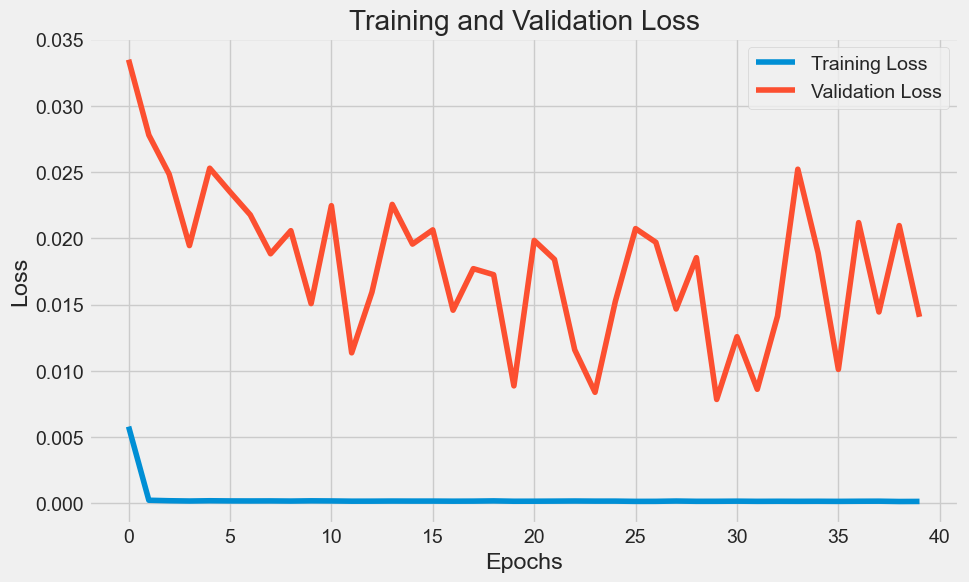

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


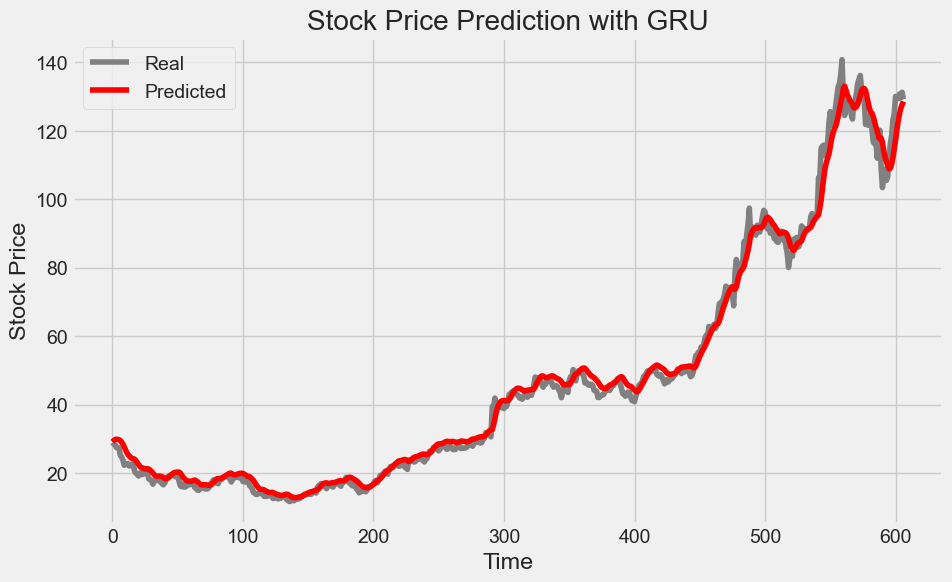

In [100]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_gru(X_train, y_train, X_test, y_test, optimizer_type='rmsprop')

In [101]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 9.30
Mean Absolute Error: 2.13
Root Mean Squared Error: 3.05
Mean Absolute Percentage Error: 5.37%


## GRU Conclusion

### Performance Summary:
The GRU model demonstrated strong predictive capability for NVIDIA stock prices, achieving the following metrics:
- **Mean Squared Error (MSE):** 9.30  
- **Mean Absolute Error (MAE):** 2.13  
- **Root Mean Squared Error (RMSE):** 3.05  
- **Mean Absolute Percentage Error (MAPE):** 5.37%  

These results indicate that the GRU model slightly outperforms both the RNN and Bi-Directional LSTM models in MSE, MAE, and RMSE. However, its MAPE is marginally higher than the Bi-Directional LSTM, suggesting a slightly weaker ability to handle relative error.

### Strengths:
- **Accuracy:** The GRU model achieved the lowest MSE, MAE, and RMSE among all tested models, demonstrating its effectiveness in minimizing absolute errors.
- **Efficiency:** GRUs are known for their computational efficiency compared to LSTMs, making them a strong alternative when balancing accuracy and resource constraints.

### Weaknesses:
- **Relative Error:** The MAPE of 5.37% is slightly higher than that of the Bi-Directional LSTM (5.19%), indicating that while the GRU performs well in absolute terms, it is slightly less effective in handling relative percentage errors.

### Comparison with Other Models:
- **Versus RNN:** The GRU model outperformed the RNN in all metrics except MAPE, suggesting it is more accurate overall for this dataset.
- **Versus LSTM:** GRU showed superior performance compared to standard LSTM configurations and even matched or exceeded Bi-Directional LSTM performance in several metrics.

### Conclusion:
The GRU model emerges as a top performer for NVIDIA stock prediction, showcasing its ability to minimize absolute errors effectively. While its relative error (MAPE) slightly lags behind the Bi-Directional LSTM, the GRU strikes a compelling balance between accuracy and computational efficiency. Given its strong performance, GRU is a viable alternative to RNN and Bi-Directional LSTM for this dataset.

Further testing on additional datasets is recommended to confirm the consistency of these findings and determine if GRU maintains its performance advantage across different data distributions.

# Autoregressive Integrated Moving Average (ARIMA)

## Key Differences from Neural Networks

| **Feature**            | **ARIMA**                         | **RNN, LSTM, GRU**                  |
|-------------------------|------------------------------------|--------------------------------------|
| **Type of Model**       | Statistical                      | Machine Learning (Neural Networks)  |
| **Data Requirements**   | Requires stationary data         | Can handle non-stationary data       |
| **Interpretability**    | Highly interpretable             | Black-box nature                    |
| **Handling Trends**     | Uses differencing (manual)       | Learns trends automatically         |
| **Feature Engineering** | Univariate (simple)              | Multivariate (can include additional features) |
| **Performance**         | Best for linear relationships    | Excels in capturing non-linear patterns |


## Steps to Apply ARIMA

1. Check Stationarity:

- Use the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.
- If the p-value is greater than 0.05, the series is not stationary, and differencing is needed.

2. Determine the Order (p, d, q):

- p: Determined from the Partial AutoCorrelation Function (PACF) plot. Peaks in the PACF at lag k suggest potential values for p.
- d: Determined by differencing until the series becomes stationary.
- q: Determined from the AutoCorrelation Function (ACF) plot. Peaks in the ACF suggest potential values for q.

3. Fit the ARIMA Model:

- Use the identified parameters (p, d, q) to fit the model.

4. Evaluate Residuals:

- Check if the residuals (errors) are white noise (random) using the Ljung-Box test or residual plots.

5. Forecast:

- Use the fitted ARIMA model to predict future values.

ADF Statistic (Original Series): 4.788776183021702, p-value: 1.0


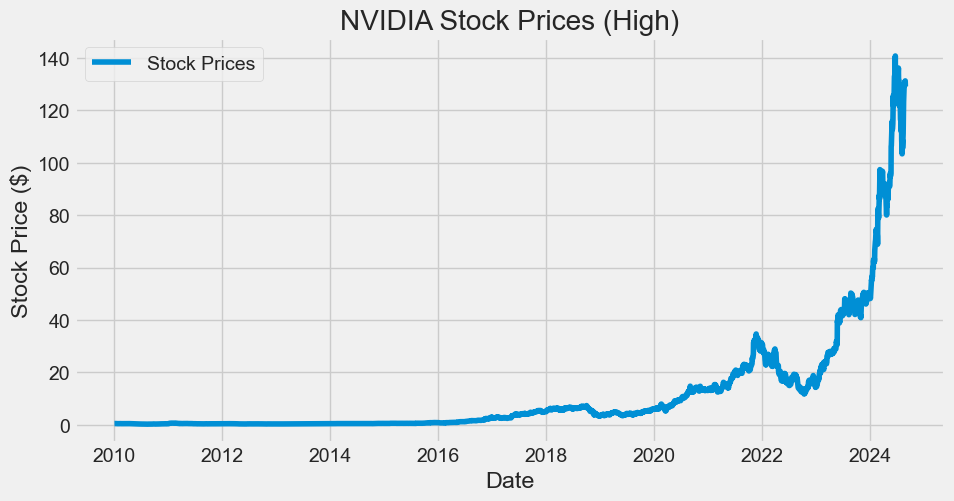

ADF Statistic (Differenced Series): -9.371874881438695, p-value: 7.340307016272582e-16


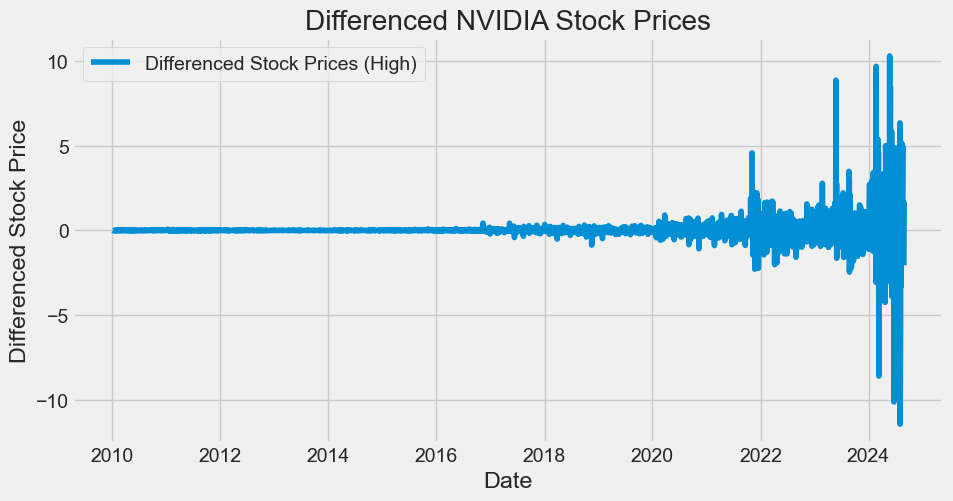

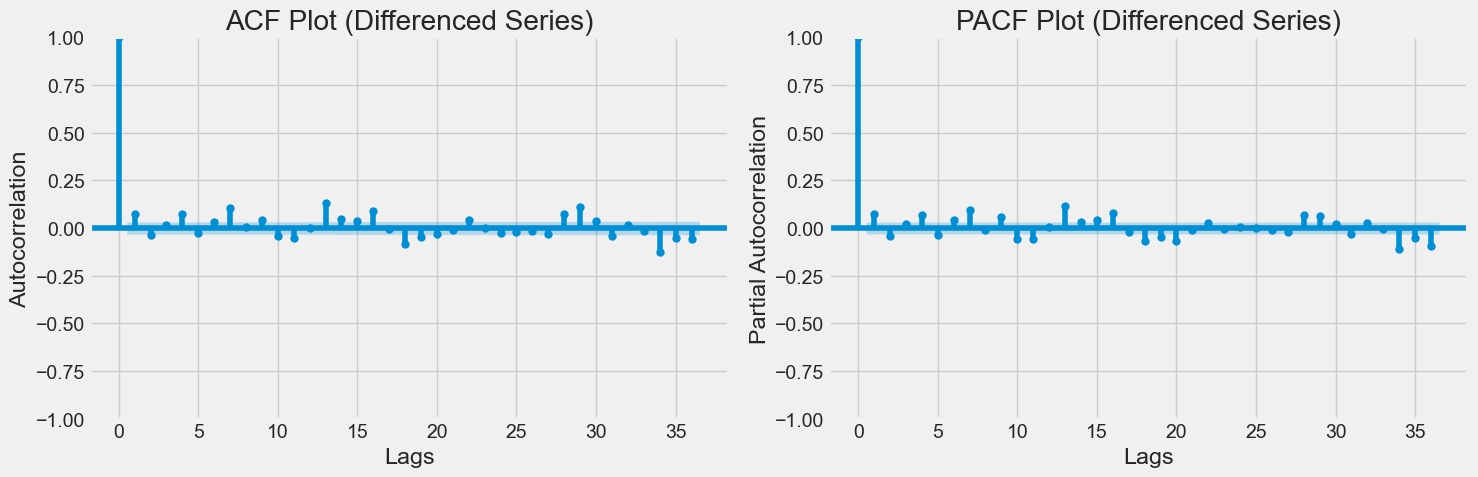

In [102]:
# Load the stock data (ensure the 'High' column is used for analysis)
nvidia_data = pd.read_csv('nvidia_stock_data.csv', index_col='Date', parse_dates=True)
stock_prices = nvidia_data['High']

# Perform the ADF test to check for stationarity
adf_result = adfuller(stock_prices)
adf_statistic, p_value = adf_result[0], adf_result[1]
print(f"ADF Statistic (Original Series): {adf_statistic}, p-value: {p_value}")

# Plot the original series to visualize the trend
plt.figure(figsize=(10, 5))
plt.plot(stock_prices, label="Stock Prices")
plt.title("NVIDIA Stock Prices (High)")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# Differencing the series to make it stationary if necessary
differenced_series = stock_prices.diff().dropna()

# Perform ADF test on the differenced series
adf_result_diff = adfuller(differenced_series)
adf_statistic_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]
print(f"ADF Statistic (Differenced Series): {adf_statistic_diff}, p-value: {p_value_diff}")

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(differenced_series, label="Differenced Stock Prices (High)")
plt.title("Differenced NVIDIA Stock Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot ACF and PACF for differenced series
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(differenced_series, ax=axes[0])
axes[0].set_title("ACF Plot (Differenced Series)")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(True)

plot_pacf(differenced_series, ax=axes[1])
axes[1].set_title("PACF Plot (Differenced Series)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Analysis of ADF Tests on Original and Differenced Series and ADF and PACF Plots

The outputs confirm the following:

1. ADF Test on Original Series:

- ADF Statistic: 4.79
- p-value: 1.0

The high p-value indicates that the original series is non-stationary, meaning it has trends or seasonality that need to be removed before proceeding.

2. ADF Test on Differenced Series:

- ADF Statistic: -9.37
- p-value: 7.34 $\times 10^{-16}$
 
This extremely low p-value confirms that the differenced series is stationary, making it suitable for ARIMA modeling.

3. ACF and PACF Plots for Differenced Series:

- The ACF plot shows a gradual decay after a few lags, indicating significant autocorrelations.
- The PACF plot cuts off sharply after lag 1 or 2, suggesting that the AR order (p) may be 1 or 2.

## Suggested Parameters for ARIMA:

Based on the above:

- d = 1 (because differencing once made the series stationary).
- p = 1 or 2 (from the PACF plot cutoff).
- q = 1 (from the ACF plot showing autocorrelations decaying slowly).

## Components of ARIMA

1. AR (AutoRegressive):

- Refers to the dependency between an observation and a number of lagged observations (previous values). 
- Example: Today's stock price might be partially influenced by the stock price of the last 3 days.
- Parameter: p (the number of lag terms).

2. I (Integrated):

- Refers to the differencing of raw observations to make the time series stationary (i.e., removing trends and seasonality). 
- Example: Subtracting yesterday’s stock price from today’s price to remove long-term trends.
- Parameter: d (the number of times differencing is applied).

3. MA (Moving Average):

- Refers to the dependency between an observation and a residual error from a moving average model applied to lagged errors. 
- Example: Today's stock price could depend on the weighted average of the last 3 days' prediction errors.
- Parameter: q (the number of lagged error terms).

In [104]:
def build_and_train_arima(dataset, column='High', p=1, d=1, q=1, log_transform=True, title="Stock Price Prediction with ARIMA"):
    """
    Builds, trains, and evaluates an ARIMA model with customizable parameters.

    Parameters:
        dataset (DataFrame): Dataset containing the time-series data
        column (str): Column name of the time-series data to predict
        p, d, q (int): ARIMA model parameters
        log_transform (bool): Whether to apply log transformation to stabilize variance
        title (str): Title for the prediction plot

    Returns:
        forecast (numpy array): Predicted values (inverse transformed if applicable)
        residuals (Series): Residuals of the ARIMA model
        metrics (dict): Dictionary containing MSE, MAE, RMSE, and MAPE
    """
    # Apply log transformation if specified
    if log_transform:
        dataset[f'{column}_log'] = np.log(dataset[column])
        data_to_use = dataset[f'{column}_log']
    else:
        data_to_use = dataset[column]
    
    # Fit ARIMA model
    model = ARIMA(data_to_use, order=(p, d, q))
    arima_result = model.fit()

    # Display ARIMA summary
    print(arima_result.summary())

    # Forecast values
    start_index = dataset.index[d]  # Starting from the first differenced value
    end_index = dataset.index[-1]  # Ending at the last index
    forecast = arima_result.predict(start=start_index, end=end_index, dynamic=False)
    
    # Reverse transformation if log_transform was applied
    if log_transform:
        forecast = np.exp(forecast)

    # Plot real vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset[column], label="Real")
    plt.plot(dataset.index[d:], forecast, color="red", label="Predicted")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Stock Price ($)")
    plt.legend()
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(dataset[column][d:], forecast)
    mae = mean_absolute_error(dataset[column][d:], forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((dataset[column][d:] - forecast) / dataset[column][d:])) * 100

    metrics = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Percentage Error': mape
    }

    # Print metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Percentage Error: {mape}%")

    # Residuals
    residuals = arima_result.resid

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label="Residuals")
    plt.title("Residuals of ARIMA Model")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.legend()
    plt.show()

    return forecast, residuals, metrics

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               High_log   No. Observations:                 3687
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8460.768
Date:                Sat, 25 Jan 2025   AIC                         -16915.537
Time:                        22:45:21   BIC                         -16896.900
Sample:                             0   HQIC                        -16908.903
                               - 3687                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0297      0.134      0.221      0.825      -0.234       0.293
ma.L1          0.0701      0.134      0.523      0.601      -0.192       0.333
sigma2         0.0006    5.8e-06    102.413      0.0

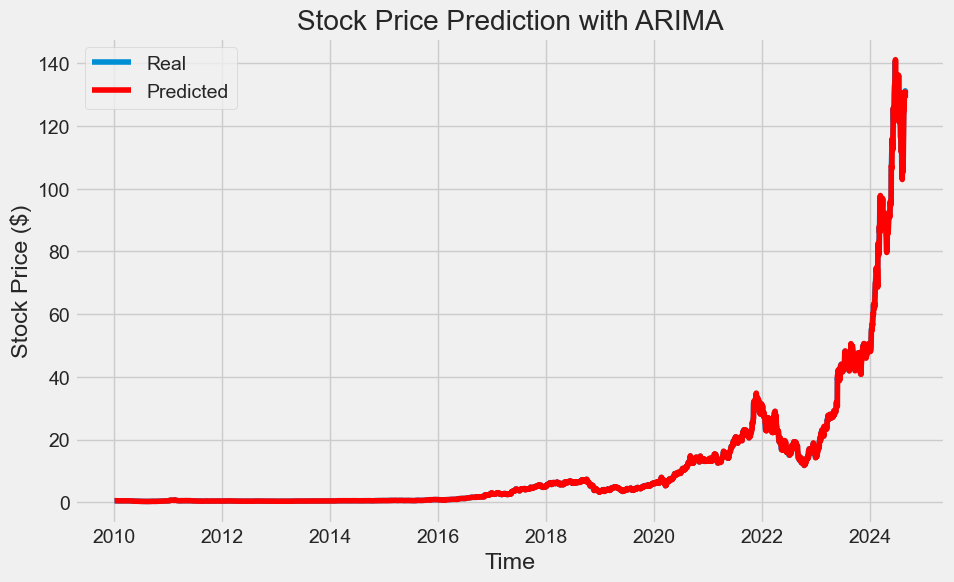

Mean Squared Error: 0.5468419438942788
Mean Absolute Error: 0.23203406614613115
Root Mean Squared Error: 0.7394876225429867
Mean Absolute Percentage Error: 1.6437062603415167%


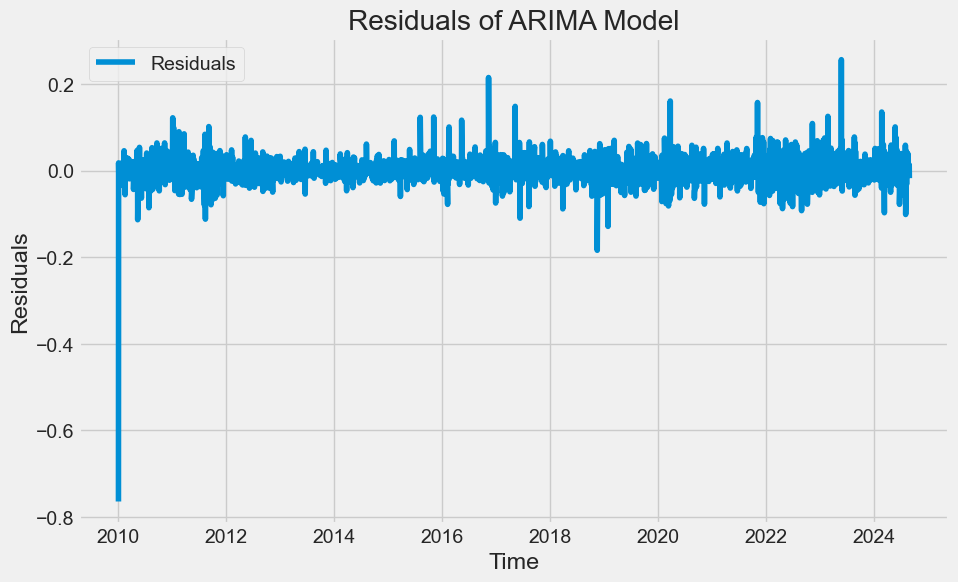

In [105]:
forecast, residuals, metrics = build_and_train_arima(dataset, column='High', p=1, d=1, q=1, log_transform=True, title="Stock Price Prediction with ARIMA")

In [106]:
def build_and_train_sarima(dataset, column='High', 
                           p=1, d=1, q=1, 
                           P=1, D=1, Q=1, s=4, 
                           log_transform=True, 
                           title="Stock Price Prediction with SARIMA"):
    """
    Builds, trains, and evaluates a SARIMA model with customizable parameters.

    Parameters:
        dataset (DataFrame): Dataset containing the time-series data
        column (str): Column name of the time-series data to predict
        p, d, q (int): Non-seasonal ARIMA model parameters
        P, D, Q, s (int): Seasonal ARIMA model parameters and seasonal period
        log_transform (bool): Whether to apply log transformation to stabilize variance
        title (str): Title for the prediction plot

    Returns:
        forecast (numpy array): Predicted values (inverse transformed if applicable)
        residuals (Series): Residuals of the SARIMA model
        metrics (dict): Dictionary containing MSE, MAE, RMSE, and MAPE
    """
    # Apply log transformation if specified
    if log_transform:
        dataset[f'{column}_log'] = np.log(dataset[column])
        data_to_use = dataset[f'{column}_log']
    else:
        data_to_use = dataset[column]
    
    # Fit SARIMA model
    sarima_model = SARIMAX(data_to_use, order=(p, d, q), seasonal_order=(P, D, Q, s))
    sarima_result = sarima_model.fit()

    # Display SARIMA summary
    print(sarima_result.summary())

    # Forecast values
    start_index = dataset.index[d]  # Starting from the first differenced value
    end_index = dataset.index[-1]  # Ending at the last index
    forecast = sarima_result.predict(start=start_index, end=end_index, dynamic=False)

    # Reverse transformation if log_transform was applied
    if log_transform:
        forecast = np.exp(forecast)

    # Plot real vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset[column], label="Real")
    plt.plot(dataset.index[d:], forecast, color="red", label="Predicted")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Stock Price ($)")
    plt.legend()
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(dataset[column][d:], forecast)
    mae = mean_absolute_error(dataset[column][d:], forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((dataset[column][d:] - forecast) / dataset[column][d:])) * 100

    metrics = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Percentage Error': mape
    }

    # Print metrics
    print(f"Mean Squared Error (SARIMA): {mse}")
    print(f"Mean Absolute Error (SARIMA): {mae}")
    print(f"Root Mean Squared Error (SARIMA): {rmse}")
    print(f"Mean Absolute Percentage Error (SARIMA): {mape}%")

    # Residuals
    residuals = sarima_result.resid

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label="Residuals")
    plt.title("Residuals of SARIMA Model")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.legend()
    plt.show()

    return forecast, residuals, metrics

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          High_log   No. Observations:                 3687
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                8443.814
Date:                           Sat, 25 Jan 2025   AIC                         -16877.628
Time:                                   22:45:23   BIC                         -16846.572
Sample:                                        0   HQIC                        -16866.573
                                          - 3687                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0288      0.140      0.205      0.837      -0.246       0.304
ma.L1          0.0681      0.140      0.486

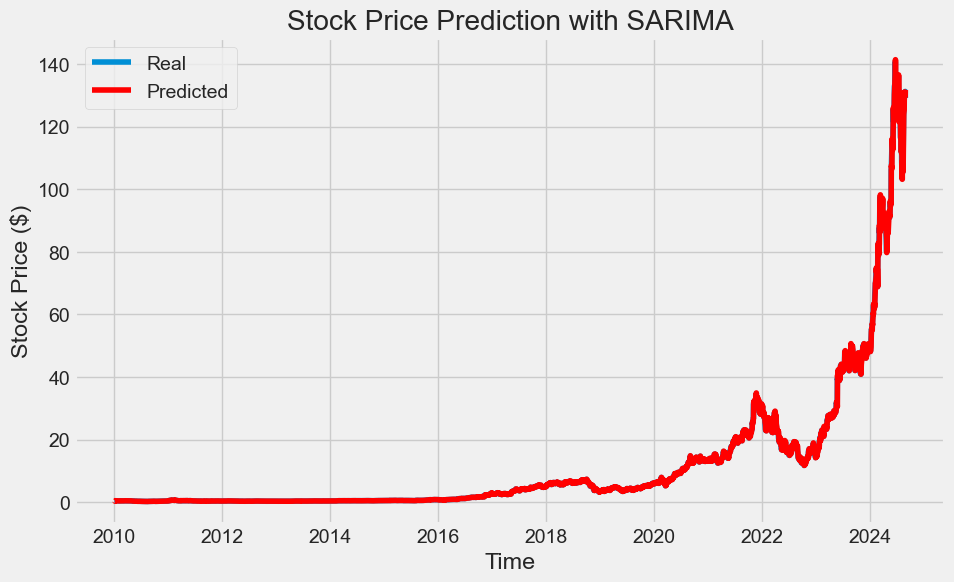

Mean Squared Error (SARIMA): 0.5476736459845518
Mean Absolute Error (SARIMA): 0.23209953843858439
Root Mean Squared Error (SARIMA): 0.7400497591274197
Mean Absolute Percentage Error (SARIMA): 1.6577887022159814%


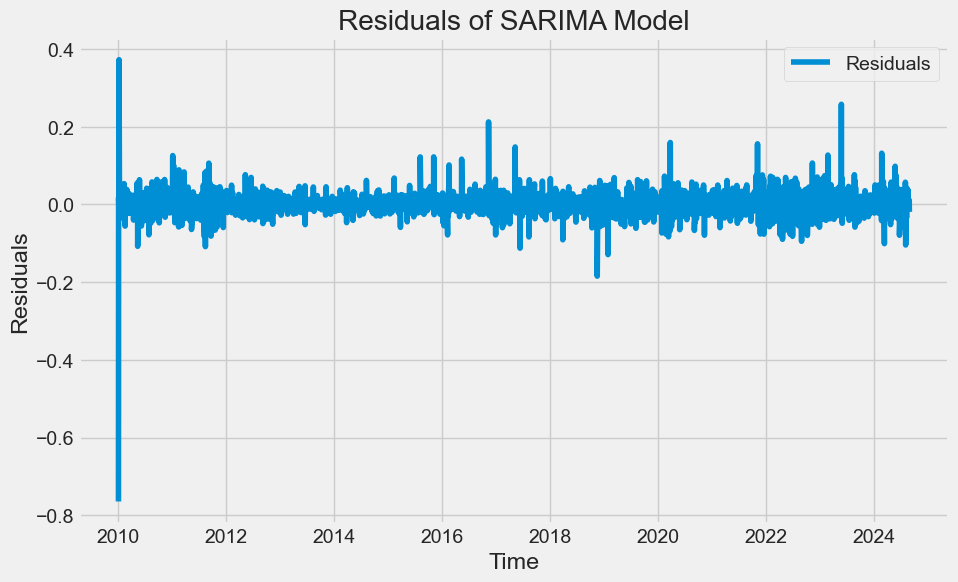

In [107]:
forecast, residuals, metrics = build_and_train_sarima(dataset, column='High', p=1, d=1, q=1, P=1, D=1, Q=1, s=4, log_transform=True, title="Stock Price Prediction with SARIMA")

## Final Conclusion for ARIMA and SARIMA Models

### ARIMA with Log Transformation

#### Performance Summary:
The ARIMA model with log-transformed data achieves the following metrics:
- **Mean Squared Error (MSE):** 0.5468  
- **Mean Absolute Error (MAE):** 0.2320  
- **Root Mean Squared Error (RMSE):** 0.7395  
- **Mean Absolute Percentage Error (MAPE):** 1.644%  

#### Observations:
- The log transformation effectively stabilizes variance and enhances the model's ability to predict stock prices during periods of exponential growth.
- Residuals from the ARIMA model are more stable and exhibit reduced variance compared to SARIMA.
- The ARIMA model consistently aligns with the actual stock price trends, showing minimal lag during rapid changes.

#### Graphical Analysis:
- **Prediction Plot:** Predicted values closely follow the real stock prices, with reduced deviations during periods of growth.
- **Residual Plot:** Residuals indicate improved stationarity and stability, supporting the suitability of the log-transformed ARIMA model for this dataset.

---

### SARIMA with Log Transformation

#### Performance Summary:
The SARIMA model with seasonal components achieves the following metrics:
- **Mean Squared Error (MSE):** 0.5477  
- **Mean Absolute Error (MAE):** 0.2321  
- **Root Mean Squared Error (RMSE):** 0.7400  
- **Mean Absolute Percentage Error (MAPE):** 1.658%  

#### Observations:
- While SARIMA captures seasonal patterns, its performance is marginally worse than the ARIMA model with log transformation, as evident from slightly higher error metrics.
- Residuals suggest some level of non-stationarity, particularly in recent periods, indicating room for further optimization.

#### Graphical Analysis:
- **Prediction Plot:** SARIMA predictions align with the overall trend of real stock prices but show noticeable lag during periods of rapid price growth.
- **Residual Plot:** Residuals exhibit heteroscedasticity, with increasing variance in later periods, suggesting limitations in capturing non-linear trends.

---

### Comparison and Conclusion:
The ARIMA model with log-transformed data outperforms the SARIMA model across all metrics, including MSE, MAE, RMSE, and MAPE. The following key insights summarize the findings:
- **ARIMA Advantages:** The log transformation stabilizes variance, improves predictive accuracy, and results in more stable residuals, making ARIMA a superior choice for this dataset.
- **SARIMA Limitations:** While SARIMA incorporates seasonal components, it struggles to match ARIMA's precision during volatile or rapidly growing periods.

Overall, ARIMA with log transformation is the preferred model for NVIDIA stock price prediction, given its lower error metrics and improved alignment with actual price trends. Further testing on additional datasets is recommended to validate the generalizability of these findings.


## NOTES

Look at literature about when LSTM performs worse than RNN

Try implementing Cross Validation with with RNN and LSTM

Different optimizers:
https://www.ruder.io/optimizing-gradient-descent/

Details about optimizers:
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/